# 02 - Image Classification Model Training 

Perform transfer learning or fine-tune a pre-trained image classification model using [Google Cloud Vertex AI](https://cloud.google.com/vertex-ai), [TensorFlow](https://www.tensorflow.org/) and [TensorFlow Hub](https://www.tensorflow.org/hub) with data generated from [02_image_classification_model.ipynb](src/02_image_classification_model.ipynb).

References:

* [Transfer learning with TensorFlow Hub  |  TensorFlow Core](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)

by: Justin Marciszewski | justinjm@google.com | AI/ML Specialist CE

## Pre-requisites 

1. Setup Google Cloud project (See [README.md](README.md) for full details )
2. Create Vertex AI Workbench instance (See [README.md](README.md) for full details )
3. Run notebook [01_generate_images.ipynb](01_generate_images.ipynb)

## Install required packages

Run the cell below to check if required packages are installed.

If any are not, they will be installed and kernel will automatically restart and show a notificaiton.

If they are already installed, nothing will happen and proceed to the next step.

In [ ]:
# tuples of (import name, install name)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('PIL', 'Pillow'),
    ('tensorflow', 'tensorflow'),
    ('sklearn', 'scikit-learn'),
    ('gcsfs', 'gcsfs')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### Restart Kernel (If Installs Occured)
After a kernel restart the code submission can start with the next cell after this one.

In [ ]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Set Constants 

In [65]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'demos-vertex-ai'

In [66]:
## TODO - SET USER FLAG (either 'test' or 'prod') #############
### test is lower cost/smaller compute and prod would be higher cost/bigger compute
### test is likely sufficient for most training jobs 
user_flag = 'test'

# Basic input validation
if user_flag not in ['test', 'prod']:
    raise ValueError("Invalid input. Please enter either 'test' or 'prod'.")
    
print("=" * 80)
print(f"User flag set to: {user_flag}")
print("=" * 80)

User flag set to: test


In [67]:
LOCATION = "us-central1"  
REGION = 'us-central1' 

EXPERIMENT = "02"
SERIES = "03-imagen-vertex-ai-fruit-and-veg"

BUCKET_NAME = f"{PROJECT_ID}-fruit-and-vegetable-image-model-imagen"

DATASET_VALIDATION_SPLIT = 0.2  # 20% for validation

## Choose values based on user flag 
if user_flag == 'test':
    MACHINE_TYPE = 'n1-standard-8'
elif user_flag == 'prod':
    MACHINE_TYPE = 'c2-standard-60' # change to prod if GCP project quota allows!

REPO_NAME = "fruit-veg-image-model-imagen-repo"
IMAGE_NAME = "tf_training"
IMAGE_TAG = "latest"
IMAGE_URI = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{REPO_NAME}/{IMAGE_NAME}:{IMAGE_TAG}"

MODEL_URI = "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5" 

DESIRED_LABELS = ["bellpepper_ripe", "apple_ripe", "banana_ripe", "bellpepper_rotten", "apple_rotten", "banana_rotten"]
NUM_CLASSES = len(DESIRED_LABELS)

## Packages

In [68]:
from datetime import datetime
import pandas as pd
from google.cloud import storage

import os
import re
import json 
import tensorflow as tf
from google.cloud import aiplatform, storage
import pandas as pd
from sklearn.model_selection import train_test_split
import tempfile  # For creating temporary files
from concurrent.futures import ThreadPoolExecutor

import threading
import time

import random
from PIL import Image  
import numpy as np

### Parameters

In [69]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
URI = f"gs://{BUCKET_NAME}/{SERIES}/{EXPERIMENT}" # for custom job -> base_output_dir = f"{URI}/models/{TIMESTAMP}",
DIR = f"temp/{EXPERIMENT}"

LOCAL_DATA_DIR = f"{DIR}/data"
LOCAL_CSV_IMAGE_DATA_PATH = f"{LOCAL_DATA_DIR}/labels.csv"

DATASET_CSV = f"{URI}/{TIMESTAMP}/labels.csv"

In [70]:
FRAMEWORK = 'tf'
TASK = 'classification'
MODEL_TYPE = 'tl'
EXPERIMENT_NAME = f'experiment-{SERIES}-{EXPERIMENT}-{FRAMEWORK}-{TASK}-{MODEL_TYPE}'
RUN_NAME = f'run-{TIMESTAMP}'

### Create a local directories for staging files 

* data files from creating labels.csv
* build files for creating custom container and running a custom job 
* model training output files and example input images for local inference

In [71]:
! rm -rf $LOCAL_DATA_DIR
! mkdir -p $LOCAL_DATA_DIR

In [72]:
if not os.path.exists(f"{DIR}/build"):
    os.makedirs(f"{DIR}/build")

In [73]:
if not os.path.exists(f"{DIR}/output"):
    os.makedirs(f"{DIR}/output")

## Clients

In [74]:
storage_client = storage.Client(project=PROJECT_ID)
aiplatform.init(project=PROJECT_ID, location=REGION)

## Enable APIs

In [75]:
%%bash
# 1. Get the list of CURRENTLY ENABLED services
enabled_services=$(gcloud services list --enabled | awk '{print $1}')

# 2. Services we WANT to ensure are enabled
services_to_enable=("storage.googleapis.com" "artifactregistry.googleapis.com" "cloudbuild.googleapis.com")

# 3. Check each desired service against the enabled list
for service in "${services_to_enable[@]}"; do
    if ! echo "$enabled_services" | grep -q "$service"; then
        echo "Enabling $service..."
        gcloud services enable "$service"
    else
        echo "$service is already enabled."
    fi
done

storage.googleapis.com is already enabled.
artifactregistry.googleapis.com is already enabled.
cloudbuild.googleapis.com is already enabled.


## Create csv labels file and upload for use in model training

Create a csv file called `labels.csv` with the schema:  `gs://filename.jpg, label` 

This file should contain no headers and be located in GCS 

In [76]:
def get_file_list(bucket_name):
    # get list of all files from bucket
    bucket = storage_client.bucket(bucket_name)
    blobs = bucket.list_blobs()
    file_list = ['gs://' + bucket_name + '/' + blob.name for blob in blobs]
    
    return file_list

In [77]:
file_list = get_file_list(BUCKET_NAME)
file_list[:10]

['gs://demos-vertex-ai-fruit-and-vegetable-image-model-imagen/data/apple_ripe_cookie_sheet_13884_20240916143128.jpg',
 'gs://demos-vertex-ai-fruit-and-vegetable-image-model-imagen/data/apple_ripe_cookie_sheet_14189_20240916143505.jpg',
 'gs://demos-vertex-ai-fruit-and-vegetable-image-model-imagen/data/apple_ripe_cookie_sheet_15307_20240916143545.jpg',
 'gs://demos-vertex-ai-fruit-and-vegetable-image-model-imagen/data/apple_ripe_cookie_sheet_18537_20240916143100.jpg',
 'gs://demos-vertex-ai-fruit-and-vegetable-image-model-imagen/data/apple_ripe_cookie_sheet_20942_20240916142558.jpg',
 'gs://demos-vertex-ai-fruit-and-vegetable-image-model-imagen/data/apple_ripe_cookie_sheet_23809_20240916143307.jpg',
 'gs://demos-vertex-ai-fruit-and-vegetable-image-model-imagen/data/apple_ripe_cookie_sheet_24576_20240916143343.jpg',
 'gs://demos-vertex-ai-fruit-and-vegetable-image-model-imagen/data/apple_ripe_cookie_sheet_36393_20240916143554.jpg',
 'gs://demos-vertex-ai-fruit-and-vegetable-image-model-i

In [78]:
def create_dataframe(file_list):
    # filter to include on filenames with jpeg filename
    jpeg_files = [file for file in file_list if file.endswith(('.jpg', '.jpeg'))]
    df = pd.DataFrame(jpeg_files, columns=['filename'])
    # Extract the label by first removing the GCS prefix, then splitting the blobname, and finally extracting the relevant part
    df['label'] = df['filename'].apply(lambda x: '_'.join(x.split('/')[-1].split('_')[:2]))   
    
    return df

In [79]:
df_data = create_dataframe(file_list)
df_data.head()

filename       label
0  gs://demos-vertex-ai-fruit-and-vegetable-image...  apple_ripe
1  gs://demos-vertex-ai-fruit-and-vegetable-image...  apple_ripe
2  gs://demos-vertex-ai-fruit-and-vegetable-image...  apple_ripe
3  gs://demos-vertex-ai-fruit-and-vegetable-image...  apple_ripe
4  gs://demos-vertex-ai-fruit-and-vegetable-image...  apple_ripe

In [80]:
df_data.shape[0]

499

In [81]:
df_data.to_csv(LOCAL_CSV_IMAGE_DATA_PATH, index=False, header=False)

In [82]:
bucket = storage_client.bucket(BUCKET_NAME)
blob = bucket.blob(f"{SERIES}/{EXPERIMENT}/{TIMESTAMP}/labels.csv") 
blob.upload_from_filename(LOCAL_CSV_IMAGE_DATA_PATH)

## Model Training

### Data pre-processing

In [83]:
# --- Preprocessing ---
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def create_tfrecord_from_gcs(gcs_path, label, tfrecord_writer, storage_client, label_map):
    """Creates a TFRecord from an image in GCS and writes it to the writer."""
    try:
        bucket_name, blob_name = gcs_path[5:].split('/', 1)
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(blob_name)
        
        with tempfile.NamedTemporaryFile() as temp_file:
            blob.download_to_filename(temp_file.name)
            with open(temp_file.name, 'rb') as image_file:
                image_string = image_file.read()

        # Convert label to integer using the label map
        label_int = label_map[label]

        feature = {
            'image/encoded': _bytes_feature(image_string),
            'image/class/label': _int64_feature(label_int)
        }
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        tfrecord_writer.write(example.SerializeToString())
    except Exception as e:
        print(f"Error processing {gcs_path}: {e}")


def create_and_upload_tfrecord(split_name, df, bucket, storage_client, label_map):
    """Creates a TFRecord file from the DataFrame and uploads it to GCS."""
    blob_name = f"{SERIES}/{EXPERIMENT}/{TIMESTAMP}/{split_name}.tfrecord"
    blob = bucket.blob(blob_name)
    writer_lock = threading.Lock()
    error_occurred = False  # Flag to track errors

    with tempfile.NamedTemporaryFile() as temp_file:
        writer = tf.io.TFRecordWriter(temp_file.name)
        for row in df.itertuples():
            try:
                create_tfrecord_from_gcs(row.image_path, row.label, writer, storage_client, label_map)
            except Exception as e:
                print(f"Error processing {row.image_path}: {e}")
                error_occurred = True  # Set the flag if an error occurs

        writer.close()

        # Check if any errors occurred before uploading
        if not error_occurred:
            blob.upload_from_filename(temp_file.name, timeout=600) # to avoid any connection timeout issues
            print(f"Uploaded {blob_name} to GCS.")
        else:
            print(f"Not uploading {blob_name} due to errors during TFRecord creation.")

# --- Main Preprocessing Function ---
def preprocess_data():
    """Reads CSV, splits data, creates label map, and creates/uploads TFRecords."""
    df = pd.read_csv(DATASET_CSV, header=None, names=['image_path', 'label'])
    train_df, val_df = train_test_split(df, test_size=DATASET_VALIDATION_SPLIT, random_state=42)

    # Create a label map (dictionary mapping labels to integer IDs)
    unique_labels = df['label'].unique()
    label_map = {label: i for i, label in enumerate(unique_labels)}

    storage_client = storage.Client(project=PROJECT_ID)
    bucket = storage_client.bucket(BUCKET_NAME)

    # save label map to GCS for use in prediction later 
    blob = bucket.blob(f"{SERIES}/{EXPERIMENT}/{TIMESTAMP}/label_map.json")  # Specify GCS path for label_map.json here
    blob.upload_from_string(json.dumps(label_map), content_type='application/json')

    create_and_upload_tfrecord('train', train_df, bucket, storage_client, label_map)
    create_and_upload_tfrecord('val', val_df, bucket, storage_client, label_map)

### Execute pre-processing 

Create TFRecords files in GCS bucket

In [84]:
preprocess_data() 

Uploaded 03-imagen-vertex-ai-fruit-and-veg/02/20240916144013/train.tfrecord to GCS.
Uploaded 03-imagen-vertex-ai-fruit-and-veg/02/20240916144013/val.tfrecord to GCS.


## Create Training Script

In [85]:
with open(f"{DIR}/build/train.py", 'w') as f:
    f.write("""import os
import tensorflow as tf
import tensorflow_hub as hub

# Get Environment Variables
TFRECORD_PATH = os.environ['AIP_TFRECORD_PATH']
VALIDATION_PATH = os.environ['AIP_VALIDATION_PATH']
OUTPUT_PATH = os.environ['AIP_OUTPUT_PATH']
MODEL_URI = os.environ['MODEL_URI']
NUM_CLASSES = os.environ['NUM_CLASSES']

# sanity check TF version
print(f"TensorFlow version: {tf.__version__}")

# Load the TFRecords
def parse_tfrecord(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/class/label': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example['image/encoded'], channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to match model input
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    label = tf.cast(example['image/class/label'], tf.int32)
    return image, label


def get_dataset(filename):
    return tf.data.TFRecordDataset(filename).map(parse_tfrecord).shuffle(1000).batch(32).prefetch(1)

train_dataset = get_dataset(TFRECORD_PATH)
val_dataset = get_dataset(VALIDATION_PATH)

# Load the TensorFlow Hub model
model = hub.KerasLayer(MODEL_URI, trainable=False)

# Add your custom classification head
### [CHECK] Ensure this is same number of classes in your dataset ### <-- [CHECK] ###
print(f"NUM_CLASSES: {NUM_CLASSES}")

model = tf.keras.Sequential([
    model,
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train the model
model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Save the model
model.save(OUTPUT_PATH)
""")

### Create Dockerfile

Refs:

* https://cloud.google.com/vertex-ai/docs/training/pre-built-containers

In [86]:
with open(f"{DIR}/build/Dockerfile", 'w') as f:
    f.write("""FROM us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-11:latest

# Set the working directory
WORKDIR /root

# Install dependencies
RUN pip install tensorflow-hub==0.12.0

# Copy the training script
COPY train.py /root/train.py

# Define the entry point
ENTRYPOINT ["python", "train.py"]
""")

## Build Container Image

### Create docker repository


In [87]:
!gcloud artifacts repositories create {REPO_NAME} --repository-format=docker --location={REGION} --description="Docker repository for fruit and vegetable image model training on Vertex AI with Imagen images"

Create request issued for: [fruit-veg-image-model-imagen-repo]
Waiting for operation [projects/demos-vertex-ai/locations/us-central1/operation
s/096287f9-44ef-4621-8302-a665db687b06] to complete...done.                    
Created repository [fruit-veg-image-model-imagen-repo].


In [88]:
# optional: uncomment if you'd like to sanity check 
# ! gcloud artifacts repositories list

### configure auth for docker

Before you push or pull container images, configure Docker to use the `gcloud` command-line tool to authenticate requests to `Artifact Registry` for your region.

In [89]:
!gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet


{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud",
    "us-central1-docker.pkg.dev": "gcloud"
  }
}
Adding credentials for: us-central1-docker.pkg.dev
gcloud credential helpers already registered correctly.


### Build container image 

In [90]:
!gcloud builds submit --region={REGION} --tag={IMAGE_URI} --timeout=1h ./{DIR}/build 

Creating temporary archive of 2 file(s) totalling 2.0 KiB before compression.
Uploading tarball of [./temp/02/build] to [gs://demos-vertex-ai_cloudbuild/source/1726497706.03082-ee86df80fbc64690aafb8aa0e12c3ae5.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/demos-vertex-ai/locations/us-central1/builds/290d174c-7fbf-4924-a2a8-a5c8c0135912].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds;region=us-central1/290d174c-7fbf-4924-a2a8-a5c8c0135912?project=746038361521 ].
Waiting for build to complete. Polling interval: 1 second(s).
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "290d174c-7fbf-4924-a2a8-a5c8c0135912"

FETCHSOURCE
Fetching storage object: gs://demos-vertex-ai_cloudbuild/source/1726497706.03082-ee86df80fbc64690aafb8aa0e12c3ae5.tgz#1726497706394091
Copying gs://demos-vertex-ai_cloudbuild/source/1726497706.03082-ee86df80fbc64690aafb8aa0e12c3ae5.tgz#1726497706394091...
/ [1 files][  1.2 KiB/  

## Custom Job Definition 


Refs 

* [Create custom training jobs  |  Vertex AI  |  Google Cloud](https://cloud.google.com/vertex-ai/docs/training/create-custom-job#create_custom_job-python_vertex_ai_sdk)

In [91]:
def create_custom_job(project_id, 
                      region, 
                      display_name, 
                      bucket_name,
                      base_output_dir,
                      machine_type,
                      labels
                     ):
    
    worker_pool_specs = [
        {
            "machine_spec": {
                "machine_type": machine_type,
            },
            "replica_count": 1,
            "container_spec": {
                "image_uri": IMAGE_URI,
                "env": [  
                    {"name": "AIP_TFRECORD_PATH", "value": f"{URI}/{TIMESTAMP}/train.tfrecord"},
                    {"name": "AIP_VALIDATION_PATH", "value": f"{URI}/{TIMESTAMP}/val.tfrecord"},
                    {"name": "AIP_OUTPUT_PATH", "value": f"{base_output_dir}/output"},
                    {"name": "AIP_MODEL_DIR", "value": f"{base_output_dir}/output"},  # <- [CHECK] Important! the model output location
                    {"name": "TFHUB_CACHE_DIR", "value": f"{base_output_dir}/tfhub_cache"}, 
                    {"name": "MODEL_URI", "value": MODEL_URI},
                    {"name": "NUM_CLASSES", "value": str(NUM_CLASSES)},
                ],
            },
        }
    ]

    custom_job = aiplatform.CustomJob(
        project=project_id,
        location=region,
        display_name=display_name,
        staging_bucket=bucket_name,
        base_output_dir=base_output_dir,
        worker_pool_specs=worker_pool_specs,
        labels=labels
    )
    
    return custom_job

###  Submit Job

In [92]:
custom_job = create_custom_job(
    project_id=PROJECT_ID,
    region=REGION,
    display_name = f'{SERIES}_{EXPERIMENT}_{TIMESTAMP}',
    bucket_name = BUCKET_NAME,  # aka - staging_bucket 
    base_output_dir = f"{URI}/models/{TIMESTAMP}", 
    machine_type=MACHINE_TYPE,
    labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}', 'run_name' : f'{RUN_NAME}'}
)

In [93]:
# Submit the custom job to Vertex AI
custom_job.run()

Creating CustomJob
CustomJob created. Resource name: projects/746038361521/locations/us-central1/customJobs/5530858051118039040
To use this CustomJob in another session:
custom_job = aiplatform.CustomJob.get('projects/746038361521/locations/us-central1/customJobs/5530858051118039040')
View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/5530858051118039040?project=746038361521
CustomJob projects/746038361521/locations/us-central1/customJobs/5530858051118039040 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/746038361521/locations/us-central1/customJobs/5530858051118039040 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/746038361521/locations/us-central1/customJobs/5530858051118039040 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/746038361521/locations/us-central1/customJobs/5530858051118039040 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/746038361521/locations/us-central1/customJobs/5530858

## Download Model for local inference

### Helper functions 

For downloading model, a sample image and finally making a prediction

In [94]:
def download_blobs_with_prefix(bucket_name, prefix, local_directory):
    
    bucket = storage_client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix)

    for blob in blobs:
        # Skip "directory" objects
        if blob.name.endswith("/"):
            continue

        # Calculate the relative path within the prefix
        relative_path = blob.name[len(prefix):] 

        # Create the local directory for the relative path
        local_file_directory = os.path.join(local_directory, os.path.dirname(relative_path))
        os.makedirs(local_file_directory, exist_ok=True)

        # Download the blob
        local_file_path = os.path.join(local_directory, relative_path)
        blob.download_to_filename(local_file_path)
        print(f"Blob {blob.name} downloaded to {local_file_path}.")

def download_random_jpg(bucket_name, pattern):

    bucket = storage_client.bucket(bucket_name)
    # Get list of blobs (files) with the pattern
    blobs = [blob for blob in bucket.list_blobs() if re.search(pattern, blob.name)]
    
    if not blobs:
        print("No files found with the pattern:", pattern)
        return None
    
    # Choose a random blob
    random_blob = random.choice(blobs)

    # Download the blob
    local_filename = random_blob.name 
    local_directory = os.path.dirname(local_filename)
    os.makedirs(local_directory, exist_ok=True)  # Ensure directory exists
    
    random_blob.download_to_filename(local_filename)
    print(f"Downloaded {local_filename} from bucket {bucket_name}")

    return local_filename

def preprocess_image(image_path, target_size=(224, 224)):
    """Preprocesses an image for model prediction."""
    img = Image.open(image_path).convert('RGB')  # Ensure RGB format
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize & set to float32
    return img_array  # Remove extra dimension (model handles batching)

### 2. Download the model

In [95]:
download_blobs_with_prefix(bucket_name=BUCKET_NAME, 
                           prefix=f"{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/output/", 
                           local_directory=f"{DIR}/output")

Blob 03-imagen-vertex-ai-fruit-and-veg/02/models/20240916144013/output/fingerprint.pb downloaded to temp/02/output/fingerprint.pb.
Blob 03-imagen-vertex-ai-fruit-and-veg/02/models/20240916144013/output/keras_metadata.pb downloaded to temp/02/output/keras_metadata.pb.
Blob 03-imagen-vertex-ai-fruit-and-veg/02/models/20240916144013/output/saved_model.pb downloaded to temp/02/output/saved_model.pb.
Blob 03-imagen-vertex-ai-fruit-and-veg/02/models/20240916144013/output/variables/variables.data-00000-of-00001 downloaded to temp/02/output/variables/variables.data-00000-of-00001.
Blob 03-imagen-vertex-ai-fruit-and-veg/02/models/20240916144013/output/variables/variables.index downloaded to temp/02/output/variables/variables.index.


### 3. Load the model

In [96]:
model = tf.saved_model.load(f"{DIR}/output")

### 4. Prepare an image for prediction

In [97]:
## download a random image 
# downloaded_file = download_random_jpg(BUCKET_NAME) 
downloaded_file = download_random_jpg(
    bucket_name=BUCKET_NAME, 
    pattern=f'({"|".join(DESIRED_LABELS)})(?!\.png$)') 

Downloaded data/banana_ripe_cutting_board_99255_20240916143655.jpg from bucket demos-vertex-ai-fruit-and-vegetable-image-model-imagen


In [98]:
## and pre-process image for prediction
preprocessed_image = preprocess_image(downloaded_file)

In [99]:
## display raw output
# preprocessed_image 

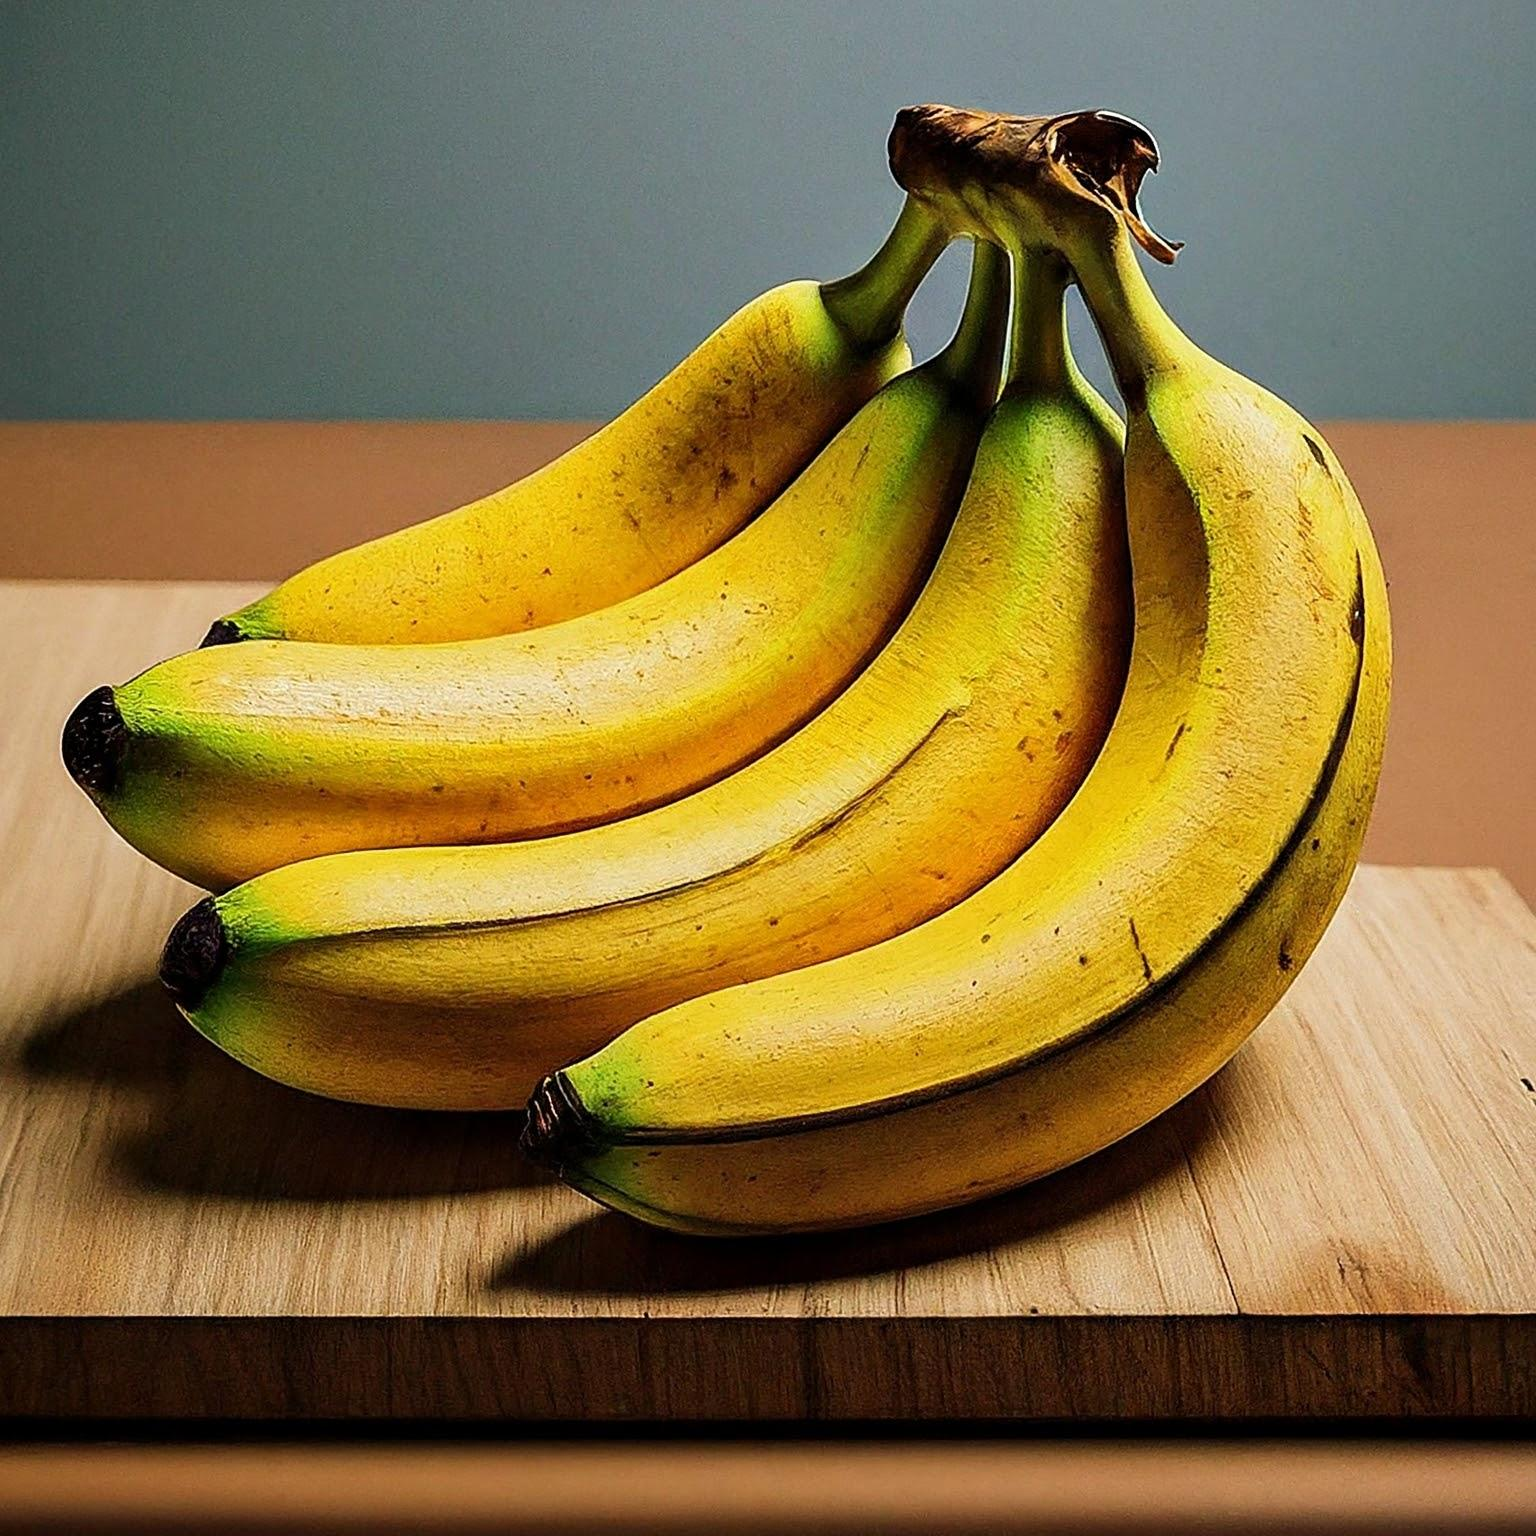

In [100]:
## display image to sanity check
display(Image.open(downloaded_file))

### 5. Make a prediction

In [101]:
# Add batch dimension
preprocessed_image = np.expand_dims(preprocessed_image, axis=0) 

# Get predictions
predictions = model(preprocessed_image)
class_probabilities = tf.nn.softmax(predictions)  # Get probabilities
predicted_class = tf.argmax(class_probabilities).numpy()

print(f"Predicted class: {predicted_class}")
print(f"Class probabilities: {class_probabilities}")

Predicted class: [0 0 0 0 0 0]
Class probabilities: [[0.12958764 0.12958738 0.35195377 0.12969635 0.12958753 0.12958732]]


get a single predicted class label, using the index of the highest probability. 

In [102]:
# predicted_class_index = tf.argmax(class_probabilities).numpy()
# print(f"Predicted Class Index: {predicted_class_index}")  

#### Get predicted class 

And finally download the `label_map.json` to lookup the predicted class name when making prediction so we have a useful output

In [103]:
bucket = storage_client.bucket(BUCKET_NAME)
blob = bucket.blob(f"{SERIES}/{EXPERIMENT}/{TIMESTAMP}/label_map.json")
label_map_json_string = blob.download_as_string()
label_map = json.loads(label_map_json_string)

predicted_class_index = tf.argmax(class_probabilities, axis=-1).numpy()[0]  # Extract scalar value
# Get the predicted class name (assuming you have predicted_class_index)
predicted_class_name = [label for label, index in label_map.items() if index == predicted_class_index][0]

print("Input File:       ", downloaded_file, "\n")
print("=" * 30, " Prediction Response", "=" * 30) 
print("\n", f"Predicted Class Name: {predicted_class_name}", "\n")
print("=" * 80)

Input File:        data/banana_ripe_cutting_board_99255_20240916143655.jpg 

==============================  Prediction Response ==============================

 Predicted Class Name: banana_ripe 



### Cleanup downloaded image

Delete the downloaded image file to keep local directory clean

In [104]:
if os.path.exists(downloaded_file):  # Check if the file exists
    os.remove(downloaded_file)
    print(f"Deleted downloaded image file: {downloaded_file}")
else:
    print(f"Downloaded image file not found: {downloaded_file}")

Deleted downloaded image file: data/banana_ripe_cutting_board_99255_20240916143655.jpg
